In [29]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
plt.set_cmap("magma")

plt.style.use('seaborn-v0_8')

<Figure size 800x550 with 0 Axes>

In [30]:
#from DA_PoC.dynamical_systems.sw_numerical_model 
from DA_PoC.dynamical_systems.examples.sw import SWModelJax
from DA_PoC.common.numerical_model import NumericalModel

from DA_PoC.common.observation_operator import LinearObservationOperator
import numpy as np

In [31]:
n_x = 32
dx = 5e3
n_y = 32
dy = 5e3
swmodel = SWModelJax(n_x, dx, n_y, dy, periodic_x=True)


In [32]:
state_dimension = 3 * swmodel.state_variable_length
obs_dimension = swmodel.state_variable_length
h_no_nan = np.eye(swmodel.state_variable_length)
for i in range(swmodel.state_variable_length):
    if i % 32 == 0:
        h_no_nan[i, i] = 0
        h_no_nan[i-1, i-1] = 0

H_obs = np.hstack(
    [
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        h_no_nan,
    ]
)
obs_operator = LinearObservationOperator(Hmatrix=H_obs)
window = 15
# print(f"{lorenz.obs.shape=}")
# print(f"{lorenz.H=}")
numerical_model_sw = NumericalModel(state_dimension, obs_dimension)
background = np.zeros(state_dimension)
background[swmodel.slice_h] = swmodel.depth
numerical_model_sw.background = background
numerical_model_sw.background_error_cov_inv = 2 * np.eye(state_dimension)
numerical_model_sw.set_observation_operator(obs_operator)
def remove_nan(array):
    return np.where(np.isnan(array), 0, array)
numerical_model_sw.set_forward(lambda x: remove_nan(swmodel.forward(x, n_steps=window, pbar=False)))
numerical_model_sw.set_tangent_linear(
    lambda x: np.asarray(swmodel.forward_TLM(x, n_steps=window)[0])
)
x0_t = background
x0_t[swmodel.slice_h] += 3 * np.random.randn(swmodel.state_variable_length)

Observation operator set already


In [33]:
# new_state = numerical_model_sw.forward_no_obs(x0_t)
def generate_obs_no_noise(x0, n_steps):
    return remove_nan(swmodel.forward(x0, n_steps=n_steps)[swmodel.slice_h])

true_obs = generate_obs_no_noise(x0_t, window)


16it [00:02,  6.89it/s]                        


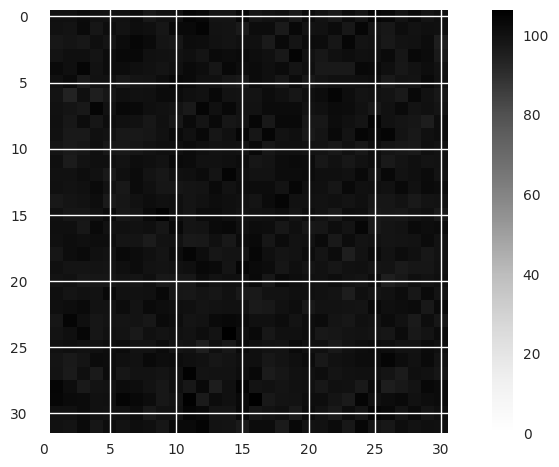

In [34]:
plt.imshow(true_obs.reshape(32, 32))
plt.colorbar()

In [35]:
true_obs

array([  0.      , 100.208046, 100.26778 , ..., 100.74256 , 100.23507 ,
         0.      ], dtype=float32)

In [36]:
noisy_obs = true_obs +  np.random.normal(loc=0, scale=0.1, size=true_obs.shape)

In [37]:
numerical_model_sw.set_obs(noisy_obs)
print(numerical_model_sw.cost_function(x0_t + np.random.normal(size=x0_t.shape)))
print(numerical_model_sw.cost_function(x0_t))

5860.202866235331
4.971908889257565


In [38]:
numerical_model_sw.cost_function(x0_t)
grad = numerical_model_sw.gradient(x0_t)

16it [00:10,  1.49it/s]                        


16it [00:10,  1.48it/s]                        


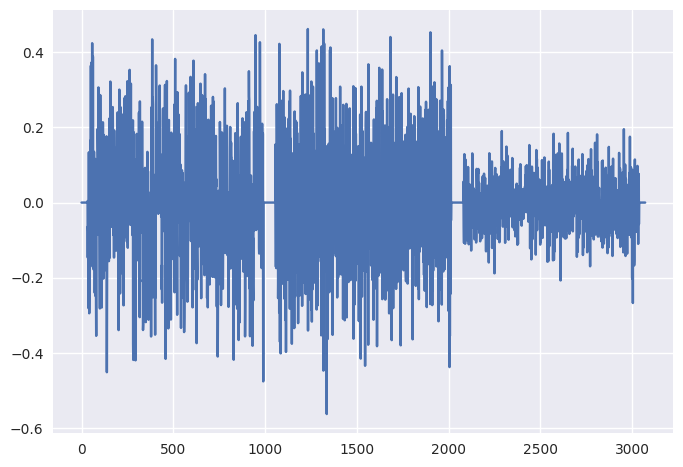

In [39]:
cost = numerical_model_sw.cost_function(x0_t)
grad = numerical_model_sw.gradient(x0_t)
plt.plot(grad)

16it [00:10,  1.59it/s]                        


4783.66766326912


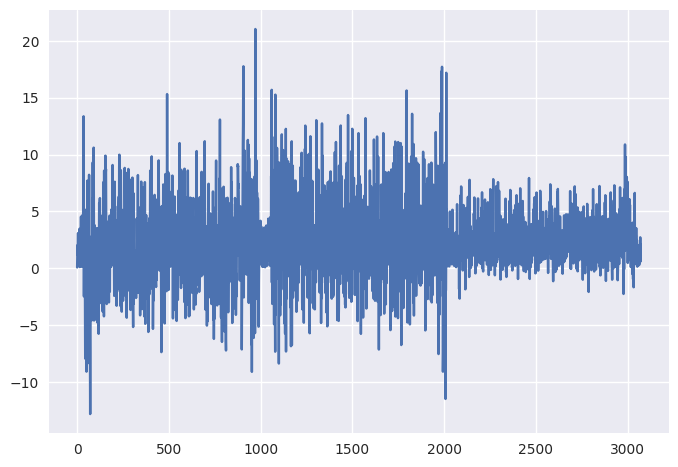

In [40]:
x1 = x0_t + np.abs(np.random.normal(size=x0_t.shape))
cost_bck = numerical_model_sw.cost_function(x1)
grad_bck = numerical_model_sw.gradient(x1)
plt.plot(grad_bck)
print(cost_bck)

In [41]:
cost_bck

4783.66766326912

In [42]:
cost

4.971908889257565

In [43]:
np.linalg.norm(grad_bck), np.linalg.norm(grad)

(219.46928370176624, 7.123034820088324)

In [44]:
gn = numerical_model_sw.gauss_newton_hessian_matrix(x1)

16it [00:09,  1.70it/s]                        


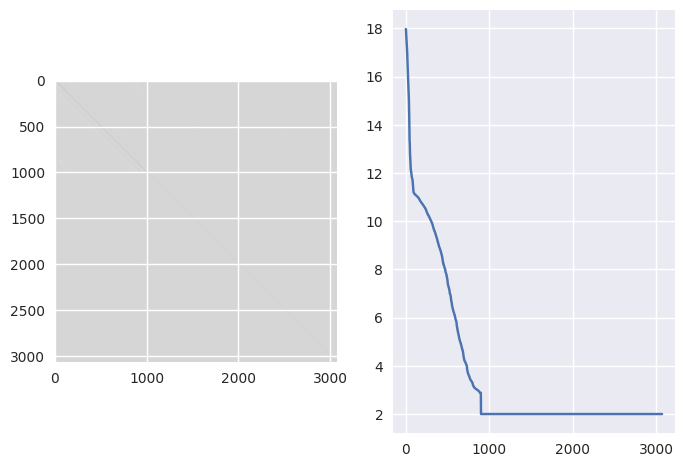

In [45]:
plt.subplot(1, 2, 1)
plt.imshow(gn)
plt.subplot(1, 2, 2)
plt.plot(np.linalg.svd(gn, compute_uv=False))

In [46]:
np.linalg.cond(gn)

8.987322211361384

In [47]:
np.sqrt(state_dimension / 3)

32.0

In [48]:
import os
os.getcwd()
from datetime import date, datetime

In [49]:
x1 = x0_t + np.abs(np.random.normal(size=x0_t.shape))


[  1.47890329   1.09642208   1.49411065 ... 101.8840869  100.48215675
 100.67682409]


5017.500979651891

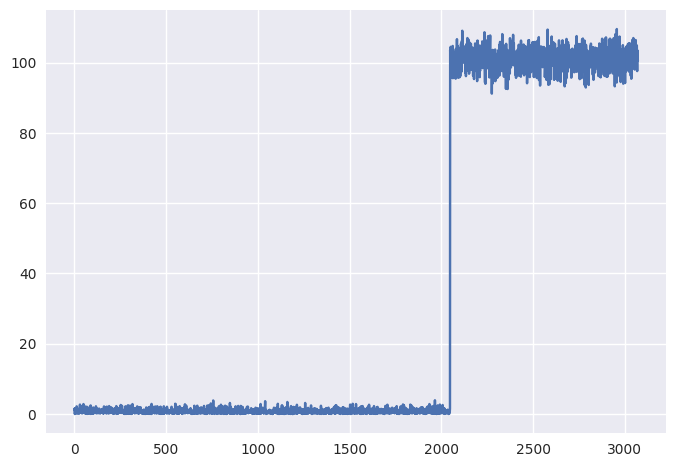

In [50]:
plt.plot(x1)
print(x1)
numerical_model_sw.cost_function(x1)

In [51]:
exp_name = datetime.now().strftime("%H:%M:%S")
gn_result = numerical_model_sw.GNmethod(
    x1,
    verbose=True,
    prec=None,
    log_file=os.path.join(os.getcwd(), "log_sw.txt"),
    exp_name=exp_name,
    i_cycle=0,
)
gn_x = gn_result['gn_x']

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


16it [00:10,  1.49it/s]                        
16it [00:11,  1.42it/s]                        
16it [00:10,  1.54it/s]                        
16it [00:10,  1.52it/s]                        


09:46:05,     0,     0, 5017.5010,       10, 3270.00, 9.002e+00, 9.002e+00


16it [00:11,  1.39it/s]                        
16it [00:11,  1.41it/s]                        
16it [00:10,  1.51it/s]                        
16it [00:10,  1.52it/s]                        


09:46:05,     0,     1,   6.5693,       10, 3267.44, 8.912e+00, 8.912e+00


16it [00:10,  1.52it/s]                        
16it [00:10,  1.57it/s]                        
16it [00:10,  1.55it/s]                        
16it [00:09,  1.67it/s]                        


09:46:05,     0,     2,   2.0329,       10, 3267.44, 8.912e+00, 8.912e+00


[1.47890329 1.09642208 1.49411065 ... 0.93438672 0.82063585 0.66740392]


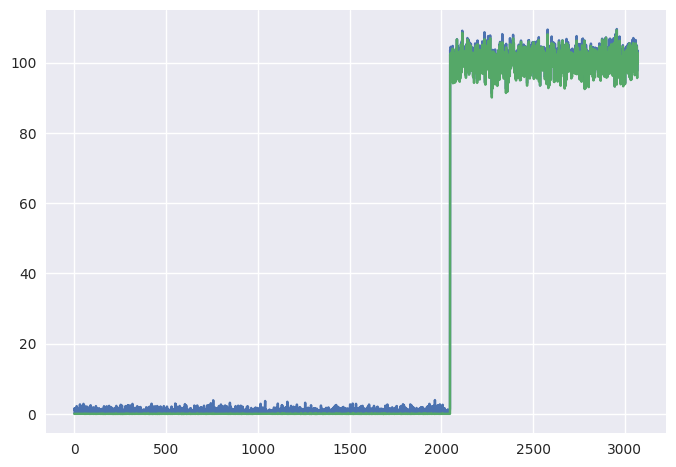

In [52]:
plt.plot(x1)
plt.plot(gn_x)
print(x1 - gn_x)

In [53]:
print(numerical_model_sw.cost_function(x1))


5017.500979651891


In [54]:
print(numerical_model_sw.cost_function(gn_result['gn_x']))

2.032924546776168


In [56]:
!pip install perlin_noise


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


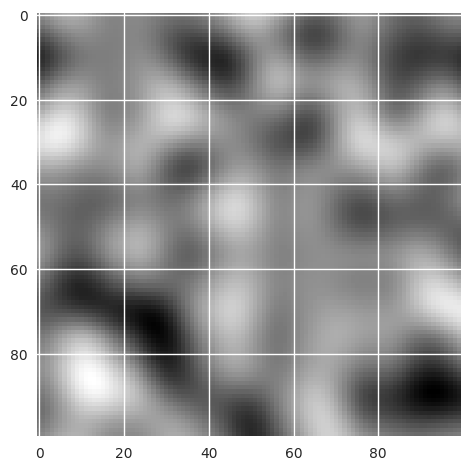

In [62]:
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=5, seed=1)
xpix, ypix = 100, 100

def generate_pic(frac_t):
    return np.asarray([[noise([i/xpix, j/ypix, frac_t]) for j in range(xpix)] for i in range(ypix)])

for i in range(10):
    plt.figure()
    pic= generate_pic(0.0)
    plt.imshow(pic, cmap='gray')
